<a href="https://colab.research.google.com/github/Priyo-prog/Time-series-analysis/blob/main/Forecasting/the_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Forecasting**

Forecasting based on simple AR(1) model

Compare the results with the actual values for each period.

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 239 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 35.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip3 install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip3 install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Delete the "!pip uninstall statsmodels" once the installation is complete

In [82]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.2 MB/s 


## Import Libraries and Packages

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA # new special package for ARIMA models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
from pmdarima import auto_arima # Auto-ARIMA model package
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set()

## Import the Data

In [6]:
raw_data = yfinance.download(tickers="^GSPC ^FTSE ^N225 ^GDAXI", start="1994-01-07", end="2018-01-29",
                             interval="1d", group_by="ticker", auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


## Preprocess the Data

In [7]:
df_comp = raw_data.copy()

In [8]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [9]:
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC'], df_comp['^GDAXI'], df_comp['^FTSE'], df_comp['^N225']

In [10]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')
df_comp.head()

,spx,dax,ftse,nikkei
,,,,
Date,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219


## Creating Returns

In [11]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

In [66]:
df_comp.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,,,,,
Date,,,,,,,,
2018-01-23,2839.129883,13559.599609,7731.799805,24124.150391,0.217437,0.212561,0.712354,1.292476
2018-01-24,2837.540039,13414.740234,7643.399902,23940.779297,-0.055998,-1.143329,-1.068316,-0.760114
2018-01-25,2839.250000,13298.360352,7615.799805,23669.490234,0.060262,-0.361097,-0.867552,-1.133167
2018-01-26,2872.870117,13340.169922,7665.500000,23631.880859,1.184120,0.652593,0.314396,-0.158894
2018-01-29,2872.870117,13340.169922,7665.500000,23629.339844,0.000000,0.000000,0.000000,-0.010752


## Splitting theTraining and Testing Sets

In [12]:
## Getting the 80% of data as training set
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The Log-Likelihood Test

In [13]:
def llr_test(mod_1, mod_2, DF=1):
   """ mod_1, mod_2= models to compare, df=degrees of freedom"""
   L1 = mod_1.fit(trend='nc').llf ## Add trend='ct'
   L2 = mod_2.fit(trend='nc').llf ## log likelihood
   LR = (2*(L2-L1)) ## test statistics
   p = chi2.sf(LR, DF).round(3) ## p-value
   return p

## Fitting a Model AR(1)

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
model_ar = ARIMA(df.ftse, order=(1,0,0))
results_ar = model_ar.fit()
print(results_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                   ftse   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27617.795
Date:                Mon, 08 Aug 2022   AIC                          55241.590
Time:                        04:09:13   BIC                          55261.153
Sample:                    01-10-1994   HQIC                         55248.445
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.9587    423.016     12.033      0.000    4260.863    5919.054
ar.L1          0.9984      0.001   1148.918      0.000       0.997       1.000
sigma2      3512.3482     40.899     85.879      0.0

## Simple Forecasting

We must choose time interval for forecasting. Choose a **start-date** and **end-date** for forecasting of time-series.

The first day after the end of the Training Set.



In [16]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,,,,,
Date,,,,,,,,
2013-04-01,1562.170044,7795.310059,6411.700195,12135.019531,-0.447358,0.000000,0.000000,-2.120443
2013-04-02,1570.250000,7943.870117,6490.700195,12003.429688,0.517226,1.232122,1.905762,-1.084381
2013-04-03,1553.689941,7874.750000,6420.299805,12362.200195,-1.054613,-1.084635,-0.870106,2.988900
2013-04-04,1559.979980,7817.390137,6344.100098,12634.540039,0.404845,-1.186856,-0.728402,2.203005
2013-04-05,1553.280029,7658.750000,6249.799805,12833.639648,-0.429490,-1.486425,-2.029324,1.575836


In [17]:
start_date = '2013-04-06'
end_date = '2014-01-01'

In [18]:
end_date = '2018-01-01'
end_date

'2018-01-01'

In [19]:
df_pred = results_ar.predict(start=start_date, end=end_date)

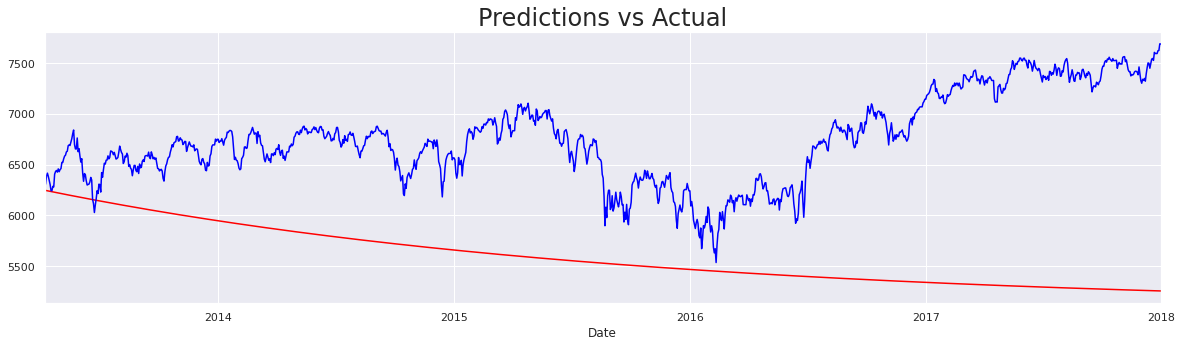

In [20]:
df_pred[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title("Predictions vs Actual", size=24)
plt.show()

We see a constantly decreasing line which is not absolutely realistic.

AR model is bad in estimating the non-stationary data.

## Using Returns Instead

In [51]:
end_date = '2018-01-01'

model_ret_ar = ARIMA(df.ret_ftse[1:], order=(1,0,0))
results_ret_ar = model_ret_ar.fit()

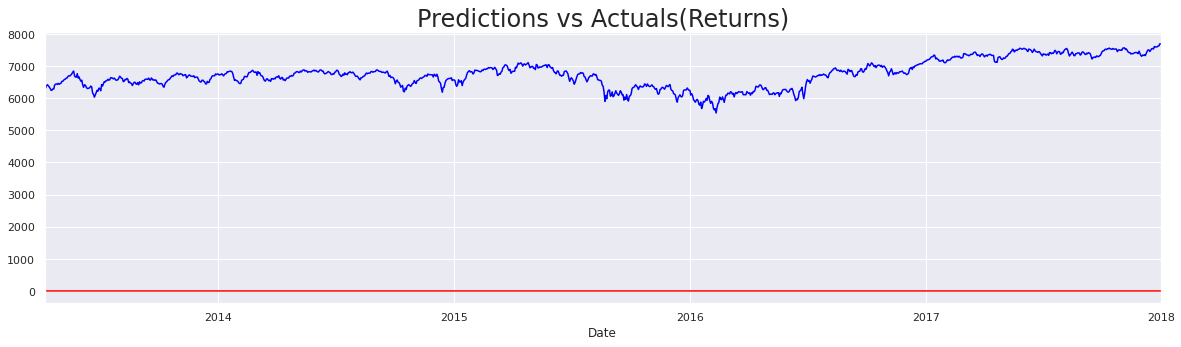

In [26]:
df_ret_pred_ar = results_ret_ar.predict(start=start_date, end=end_date)

df_ret_pred_ar[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals(Returns)", size=24)
plt.show()

The prediction line is constant at 0, it makes no prediction since it assumes that all future returns will be 0, or extremely close to it.

## MA Model

In [23]:
model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

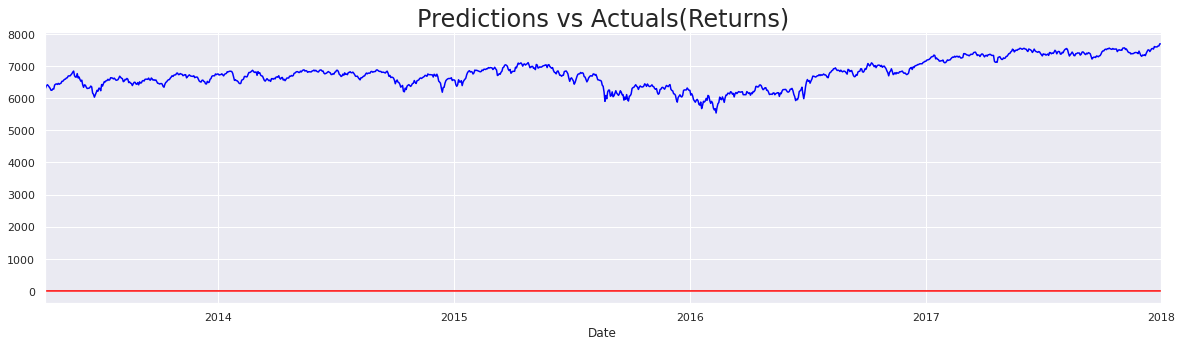

In [24]:
df_ret_pred_ma = results_ret_ma.predict(start=start_date, end=end_date)

df_ret_pred_ma[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals(Returns)", size=24)
plt.show()

In [25]:
df_ret_pred_ma.head()

2013-04-08    0.058337
2013-04-09    0.018805
2013-04-10    0.018805
2013-04-11    0.018805
2013-04-12    0.018805
Freq: B, Name: predicted_mean, dtype: float64

## ARMA Model

In [29]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

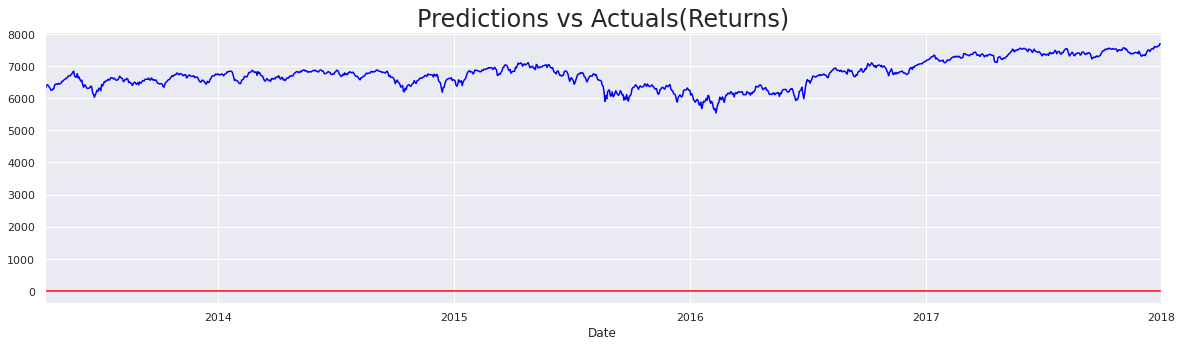

In [30]:
df_ret_pred_arma = results_ret_arma.predict(start=start_date, end=end_date)

df_ret_pred_arma[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals(Returns)", size=24)
plt.show()

## ARMAX Model

In [68]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog=df[["ret_spx", "ret_dax", "ret_nikkei"]][1:], order=(1,0,1))
results_ret_armax = model_ret_armax.fit()

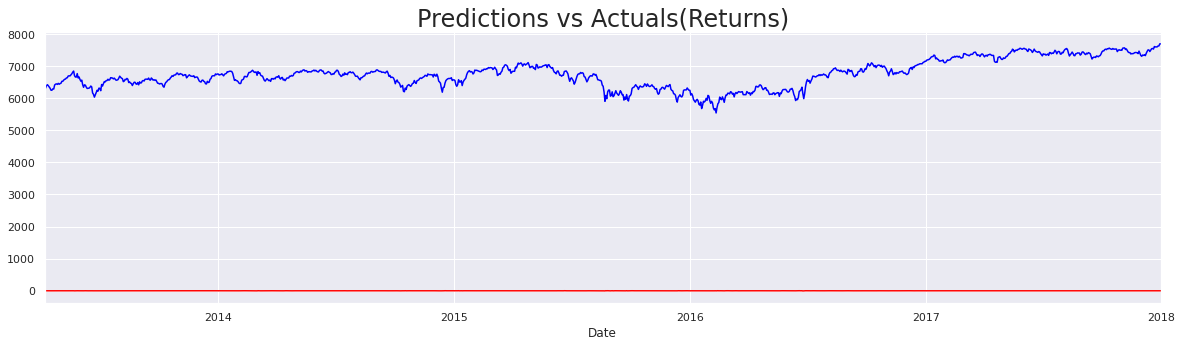

In [70]:
df_test_1 = df_test[["ret_spx", "ret_dax", "ret_nikkei"]][0:1236]

df_ret_pred_armax = results_ret_armax.predict(start=start_date, end=end_date,
                                              exog=df_test_1)

df_ret_pred_armax[start_date:end_date].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals(Returns)", size=24)
plt.show()

Real ARMA models can't incorporate any outside real-world effects.

We're allowing the model to take into account data from today.

**Cons of ARMAX forecasting :**

They can make forecasting impossible.

**predictions :** in sample estimations

**forecasting :** out of sample estimations.

In Testing data we have **exogenous** variable, where as in future the data may not have **exogenous** variables, so it may be impossible to forecast.


## SARMA Model

Advanced Seasonal Forecasting

In [73]:
end_date_1 ="2015-01-01"

model_ret_sarma = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5))
results_ret_sarma = model_ret_sarma.fit() 

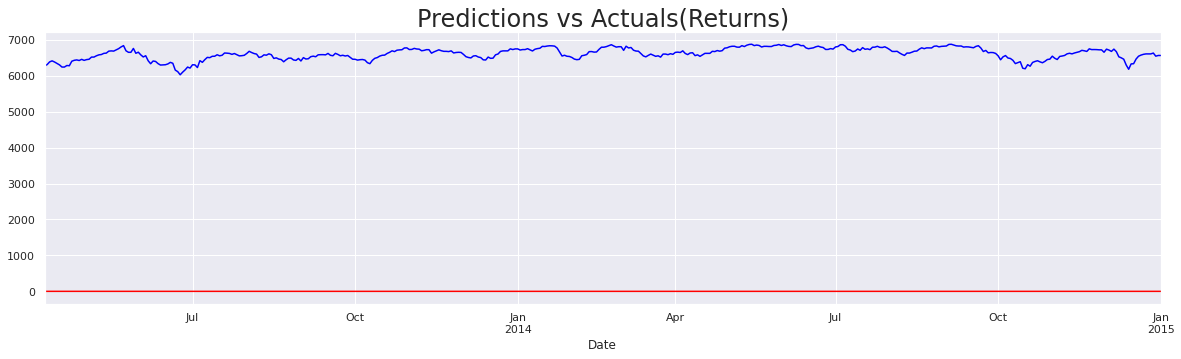

In [74]:
df_ret_pred_sarma = results_ret_sarma.predict(start=start_date, end=end_date_1)

df_ret_pred_sarma[start_date:end_date_1].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date_1].plot(color="blue")
plt.title("Predictions vs Actuals(Returns)", size=24)
plt.show()

## SARIMAX Models

In [79]:
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog=df[["ret_spx", "ret_dax", "ret_nikkei"]][1:], 
                          order=(3,0,4), seasonal_order=(3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit() 

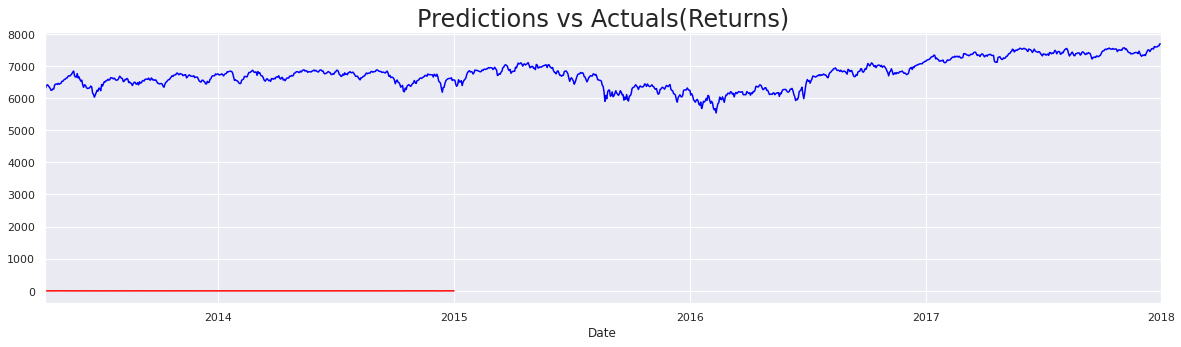

In [81]:
df_test_1 = df_test[["ret_spx", "ret_dax", "ret_nikkei"]][0:454]

df_ret_pred_sarimax = results_ret_sarimax.predict(start=start_date, end=end_date_1,
                                              exog=df_test_1)

df_ret_pred_sarimax[start_date:end_date_1].plot(figsize=(20,5), color="red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actuals(Returns)", size=24)
plt.show()

## Auto-ARIMA Model

In [84]:
model_auto = auto_arima(df.ret_ftse[1:])

In [85]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date])),
                            index=df_test[start_date:end_date].index)

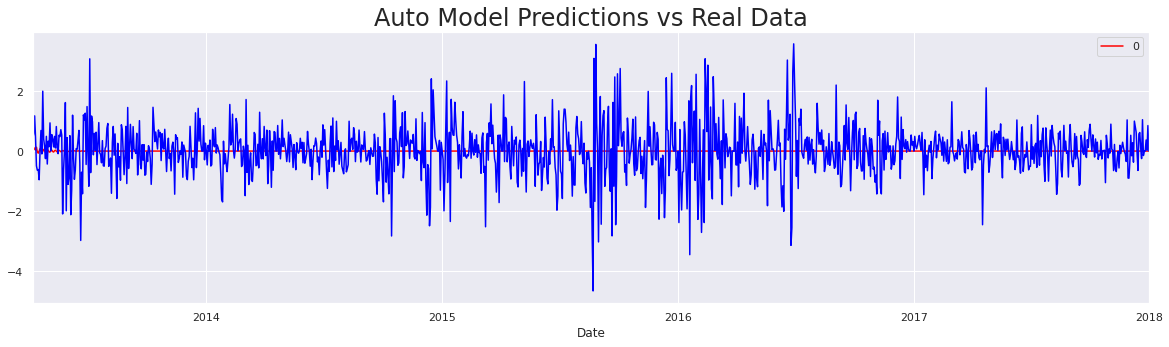

In [86]:
df_auto_pred.plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("Auto Model Predictions vs Real Data", size=24)
plt.show()

In [88]:
## Passing 'exogenous' varaibles
model_auto_x = auto_arima(df.ret_ftse[1:], exogenous = df[["ret_spx", "ret_dax", "ret_nikkei"]][1:],
                          m=5, max_p=5, max_q=5, max_P=5, max_Q=5)

In [90]:
df_auto_pred_x = pd.DataFrame(model_auto_x.predict(n_periods=len(df_test[start_date:end_date]),
                              exogenous = df_test[["ret_spx", "ret_dax", "ret_nikkei"]][start_date:end_date]),
                              index=df_test[start_date:end_date].index)

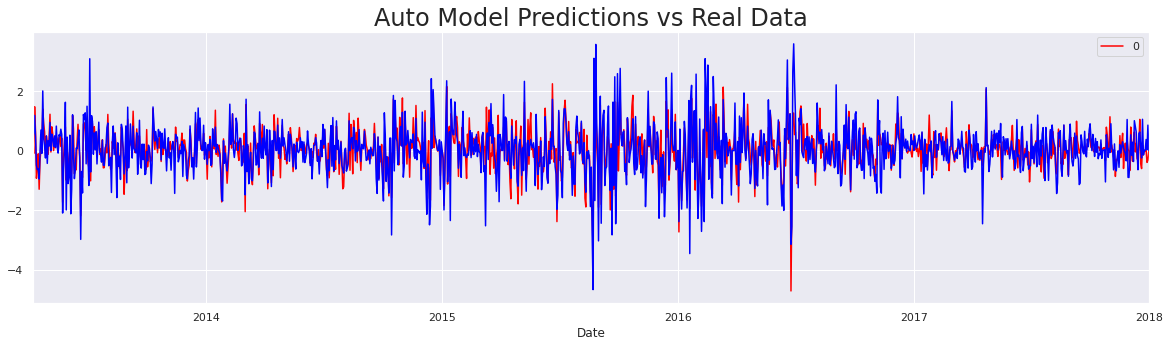

In [91]:
df_auto_pred_x.plot(figsize=(20,5), color="red")
df_test.ret_ftse[start_date:end_date].plot(color="blue")
plt.title("Auto Model Predictions vs Real Data", size=24)
plt.show()

## Forecasting Volatility

In [94]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol="GARCH", p=1, q=1, mean="constant", dist="Normal")
res_garch = mod_garch.fit(last_obs=start_date, update_freq=10)

Iteration:     10,   Func. Count:     64,   Neg. LLF: 6969.541857765137
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6969.541746399343
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


Arguements:

**horizon :** - 1 for each date

**align :** - determines whether we match the value with the date the prediction is made on, or the one it's supposed to represent

**zorder :** - the zorder determines the way different objects are stacked on the same graph

In [95]:
pred_garch = res_garch.forecast(horizon=1, align='target')

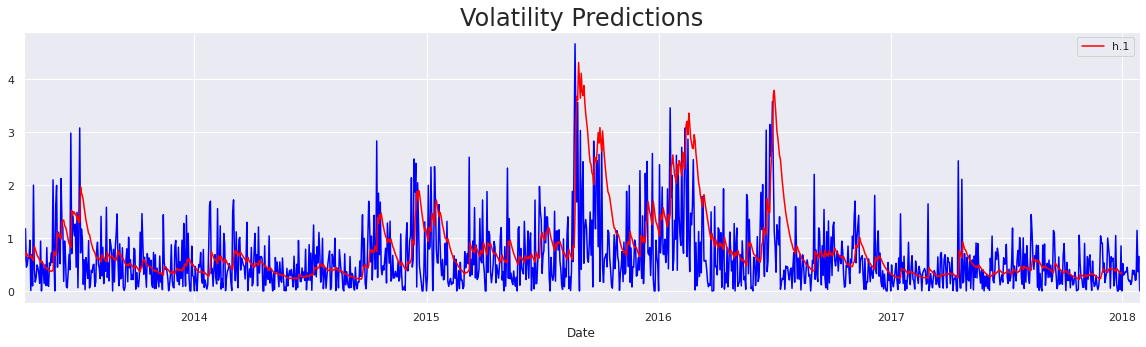

In [98]:
pred_garch.residual_variance[start_date:end_date].plot(figsize=(20,5), color="red", zorder=2)
df_test.ret_ftse.abs().plot(color="blue", zorder=1 )
plt.title("Volatility Predictions", size=24)
plt.show()

In [99]:
pred_garch = res_garch.forecast(horizon=100, align="target")
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-29,0.34338,0.340451,0.354676,0.257211,0.274408,0.289322,0.299827,0.309059,0.312913,0.328869,...,0.923172,0.925721,0.943127,0.962387,0.980361,0.992343,0.957662,0.91496,0.924863,0.93784


## Multivariate Reression

Regressions stacked on top of one another.

How do we tell these multivariate models apart ?

Vector -> Every component contains a value for each of the time series. 

example : vector ->['SPX', 'DAX', 'NIKKEI']

if we want to deal with the past values then we will have to use **Vector Autoregressive Model(VAR)**

In [100]:
from statsmodels.tsa.api import VAR

In [101]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [102]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic='aic')

In [103]:
print(results_var_ret.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Aug, 2022
Time:                     08:41:35
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.449050
Nobs:                     5014.00    HQIC:                  0.378098
Log likelihood:          -29226.2    FPE:                    1.40470
AIC:                     0.339820    Det(Omega_mle):         1.38141
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.035802         0.017040            2.101           0.036
L1.ret_spx           -0.112462         0.018140           -6.200           0.000
L1.ret_dax            0.064253         0.019679           